In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import KDTree, BallTree
from rdkit import Chem
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
from indigo import Indigo
import concurrent
from sklearn.neighbors import KDTree, BallTree
import pickle

# Query molecule

In [2]:
smiles_to_test = 'NCCc1ccc4c(c1)OCCO4'

In [3]:
m = Chem.MolFromSmiles(smiles_to_test)

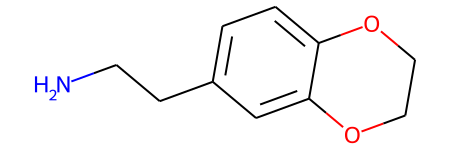

In [4]:
m

In [5]:
indigo_mol_to_test = Indigo().loadMolecule(smiles_to_test)

In [6]:
def bin_format(number, num_of_bits=3736):
    return np.fromiter(map(int, list(bin(int(number, 16))[2:].zfill(num_of_bits))), dtype=int)

In [7]:
fingerprint = pd.Series(bin_format(indigo_mol_to_test.fingerprint("sub").toString()))

In [8]:
fingerprint.index = fingerprint.index.astype(str)

# Prepare data

In [9]:
fingerprints_db = dict()

In [10]:
def handle_sdf_files(sdf_filenames, output_name):
    fingerprints_db = dict()
    for sdf_filename in sdf_filenames:
        print(sdf_filename)
        indigo_sdf = Indigo().iterateSDFile(sdf_filename)
        for ind, mol in enumerate(indigo_sdf):
            mol.aromatize()
            try:
                fingerprints_db[mol.smiles()] = bin_format(mol.fingerprint("sub").toString())
            except Exception as e:
                print(e)
    df = pd.DataFrame(fingerprints_db)
    df = df.drop_duplicates().T
    df.to_pickle(output_name)

In [11]:
sdf_filenames = ['../data/sdf/119697.sdf']

In [12]:
fingerprint_db_name = "df.pickle"

In [13]:
%%time
handle_sdf_files(sdf_filenames, fingerprint_db_name)

../data/sdf/119697.sdf
CPU times: user 2min 29s, sys: 7.55 s, total: 2min 37s
Wall time: 2min 38s


In [14]:
%%time
df = pd.read_pickle(fingerprint_db_name)

CPU times: user 11.8 ms, sys: 606 ms, total: 618 ms
Wall time: 617 ms


In [15]:
fingerprint = fingerprint[df.columns]

## Build Tree

In [16]:
R_EPS = 0.00001

In [17]:
%%time
tree = BallTree(df.values, leaf_size=2, metric='russellrao')

CPU times: user 27.7 s, sys: 917 ms, total: 28.6 s
Wall time: 28.6 s


In [18]:
%%time
r = (1 - sum(fingerprint) / len(fingerprint))
ind = tree.query_radius([fingerprint], r=r + R_EPS)   

CPU times: user 336 ms, sys: 32.3 ms, total: 368 ms
Wall time: 367 ms


In [19]:
def count_one(x):
    return sum(x & fingerprint)

In [20]:
count_one(fingerprint)

518

In [21]:
for idx, i in enumerate(ind[0]):
    print(idx, i, count_one(df.iloc[i].values))

0 8792 518
1 16343 518
2 20278 518
3 6431 518
4 11735 518
5 20847 518
6 33549 518
7 33550 518
8 34757 518
9 160 518
10 161 518
11 10172 518
12 8791 518
13 14578 518
14 16344 518
15 16345 518
16 28955 518
17 7749 518
18 11237 518
19 14999 518
20 15004 518
21 16369 518
22 16383 518
23 44485 518
24 35544 518
25 44579 518
26 40508 518
27 43595 518
28 56971 518
29 56978 518
30 56981 518
31 56422 518
32 56983 518
33 56984 518
34 56985 518
35 56982 518
36 56295 518
37 56975 518
38 56977 518
39 56989 518
40 56968 518
41 56970 518
42 56972 518
43 56976 518
44 56979 518
45 56682 518
46 56974 518
47 277 518
48 278 518
49 807 518
50 808 518
51 6318 518
52 6319 518
53 6320 518
54 6321 518
55 6322 518
56 6323 518
57 6324 518
58 6325 518
59 5094 518
60 5095 518
61 14499 518
62 6665 518
63 15003 518
64 16342 518
65 8348 518
66 10500 518
67 13171 518
68 16341 518
69 16353 518
70 16354 518
71 16359 518
72 16362 518
73 16370 518
74 16372 518
75 42771 518
76 52784 518
77 44019 518
78 56964 518
79 56965 51

In [22]:
imgs = [Chem.Draw.MolToImage(Chem.MolFromSmiles(df.index[i])) for i in ind[0]]

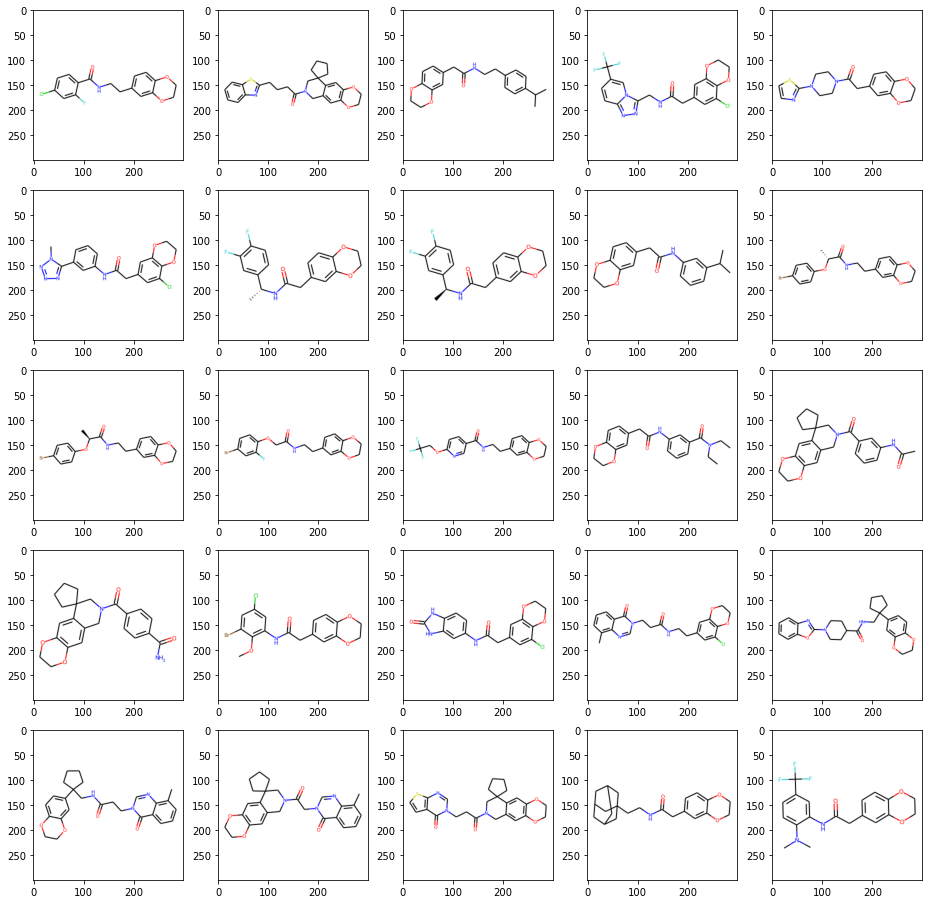

In [23]:
_, axs = plt.subplots(5, 5, figsize=(16, 16))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()